In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.hedging_utils as hu
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [167]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
mu=0.1
sigma = 0.2
q = 0
T = 20/52 
K = 50
type = 'c'
M=100000
N=1

In [168]:
np.seterr(divide='ignore')
T_array = np.linspace(T, 0, M)
dt = T_array[1] - T_array[2]
S = hu.simulate_gbm(S0, T_array, sigma, mu, q, M)
bs_price_array = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type, display_result=False)*(-option_exposure)
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
hedging_df = pd.DataFrame(zip(S, delta_array, bs_price_array), columns=['Stock_Price', 'Delta', 'BS_Price'])
hedging_df['Stock_Price_Change'] = hedging_df['Stock_Price'].sub(hedging_df['Stock_Price'].shift())
hedging_df['Shares_Held'] = -option_exposure*hedging_df['Delta']
hedging_df['Total_Stock_Position'] = hedging_df['Shares_Held']*hedging_df['Stock_Price']
hedging_df['Money_Market_Position'] = np.nan
hedging_df['Money_Market_Position'].iloc[0] = hedging_df['BS_Price'].iloc[0] - hedging_df['Total_Stock_Position'].iloc[0]
hedging_df['Interest'] = np.nan
hedging_df['Interest'].iloc[0] = 0
hedging_df['Hedging_Portfolio_Value'] = hedging_df['Total_Stock_Position'] + hedging_df['Money_Market_Position']

for i in range(1, len(T_array)):
    hedging_df['Interest'].iloc[i] = hedging_df['Money_Market_Position'].iloc[i-1]*r*dt
    hedging_df['Hedging_Portfolio_Value'].iloc[i] = hedging_df['Hedging_Portfolio_Value'].iloc[i-1] + hedging_df['Shares_Held'].iloc[i-1]*hedging_df['Stock_Price_Change'].iloc[i] + hedging_df['Interest'].iloc[i]
    hedging_df['Money_Market_Position'].iloc[i] = hedging_df['Hedging_Portfolio_Value'].iloc[i] - hedging_df['Total_Stock_Position'].iloc[i]
hedging_df['Delta_Hedge_Difference'] = hedging_df['Hedging_Portfolio_Value'].sub(hedging_df['BS_Price'])
hedging_df

Hedging PnL: $1295.9733331802167


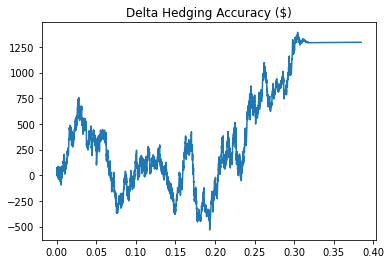

In [ ]:
# Plot Delta-Hedge PnL
hedging_pnl = hedging_df['Delta_Hedge_Difference'].iloc[-1]
print(f'Hedging PnL: ${hedging_pnl}')
plt.plot(np.flip(T_array), hedging_df['Delta_Hedge_Difference'])
plt.title('Delta Hedging Accuracy ($)')
#plt.ylim(-1, 1)
plt.show()
